# Visualize timestamps of outcomes per feature
This notebook plots timestamps of responses per feature and tries to find patterns. Are there certain moments in time when certain stations, lines or features produce significant more faulty products?

Observations:
- There are lot of duplicates!!! A lot of features show exactly the same behavior in time.
- There are significant differences between lines. Differences between stations can be small. Differences within a station is typically very small.
- Trends:
    - Line number 3 was put out of production (that is what I think) after increased amount of faults. Directly after start-up still signicant amount of faults, but that slowly declined.
    - Same trend can be identified in line 1, but it is less clear.
    - Line 1 has higher absolute levels of faulty products. Also varies a lot in time.

In [78]:
import os
import re
import pickle

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix

%matplotlib inline

# Custom modules
import const
import func

## Load data

In [79]:
const.TRAIN_FILES

['train_numeric', 'train_categorical_to_num', 'train_date']

In [80]:
[num_info, cat_info, date_info] = [func.get_station_info(f) for f in c.TRAIN_FILES]

# Date features refer to numeric/categorical features
date_info['ref_feat_nr'] = date_info['feature_nr'] - 1

In [81]:
num_data = func.load_data_file(const.TRAIN_FILES[0])
date_data = func.load_data_file(const.TRAIN_FILES[2])

Returning <open file '/Volumes/My Book/kaggle_bosch/train_numeric.pkl', mode 'rb' at 0x118d2c270>
Returning <open file '/Volumes/My Book/kaggle_bosch/train_date.pkl', mode 'rb' at 0x118d2c270>


In [82]:
date_info.head(20)

,line,station,feature_nr,ref_feat_nr
0,0,0,1,0
1,0,0,3,2
2,0,0,5,4
3,0,0,7,6
4,0,0,9,8
5,0,0,11,10
6,0,0,13,12
7,0,0,15,14
8,0,0,17,16
9,0,0,19,18


In [83]:
def plot_dates_outcome_feature(date_dict, feature_nr, time_window=100):
    ''' plot the timestamps and time-windowed sums'''
    
    t_fault, t_no_fault = get_faults_timestamps(date_dict, feature_nr)
    
    bins, f_no_fault, f_fault = get_faults_time_windowed(date_dict, feature_nr, time_window)
    
    r_fault = np.divide(f_fault.astype(float), f_no_fault)
    
    
    f, (ax1,ax2, ax3, ax4) = plt.subplots(4,1,figsize=(16,12), sharex=True)
    
    ax1.plot(t_fault, rand_jitter(np.ones(t_fault.shape)), marker='.', linestyle='None', color='r')
    ax1.plot(t_no_fault, rand_jitter(np.zeros(t_no_fault.shape)), marker='.', linestyle='None', color='g')
    
    ax1.set_ylabel('Outcome (jittered)')
    ax1.set_title(str(feature_nr))
    ax1.set_xlim([0, 1713.71])
    
    ax2.bar(bins,f_no_fault , width=1700/time_window, color='g')
    ax2.set_ylabel('No fault count')
    
    ax3.bar(bins,f_fault , width=1700/time_window, color='r')
    ax3.set_ylabel('Fault count')
    
    ax4.bar(bins,r_fault , width=1700/time_window)
    ax4.set_ylabel('Relative faults')
    ax4.set_xlabel('Timestamp (-)')
    
def get_faults_sample_nr(data_dict):
    ''' returns sample nr of samples with and without faults'''
    
    # Get response values and list of sample nr / ids
    y = data_dict['data']['y']
    ids = data_dict['data']['ids']
    
    # Get sample id for responses
    id_fault = y[y.Response==1].index.values
    id_no_fault = y[y.Response==0].index.values
    
    # Transform to sample IDs
    n_fault = ids[ids.Id.isin(id_fault)].index.values
    n_no_fault = ids[ids.Id.isin(id_no_fault)].index.values
    
    return n_fault, n_no_fault

def get_faults_timestamps(date_dict, feature_nr):
    ''' returns timestamps of samples with and without faults for given feature nr'''

    n_fault, n_no_fault = get_faults_sample_nr(date_dict)
    
    t_all = date_dict['data']['features'][:,feature_nr].todense().A1
    t_fault = t_all[n_fault]
    t_no_fault = t_all[n_no_fault]
    
    # Remove elements without timestamp from lists (missing values are converted to zeros)
    filt = t_all>0
    t_all = t_all[t_all>0]
    t_fault = t_fault[t_fault>0]
    t_no_fault = t_no_fault[t_no_fault>0]
    
    return t_fault, t_no_fault
    
def get_faults_time_windowed(date_dict, feature_nr, time_window=100):
    ''' returns sum of samples with and without faults for given feature nr during time window'''
    
    t_fault, t_no_fault = get_faults_timestamps(date_dict, feature_nr)
    
    f_no_fault, bins = np.histogram(t_no_fault, bins=time_window, range=(0, 1713.71))
    f_fault, bins = np.histogram(t_fault, bins=time_window, range=(0, 1713.71))
    
    return bins[0:-1], f_no_fault, f_fault

    
def rand_jitter(arr):
    stdev = .03*(max(arr)-min(arr))
    stdev = 0.03
    return arr + np.random.randn(len(arr)) * stdev

## Visualize timing of outcomes per station

In [99]:
date_info[date_info.line==1]

,line,station,feature_nr,ref_feat_nr
184,1,24,677,676
185,1,24,681,680
186,1,24,685,684
187,1,24,689,688
188,1,24,693,692
189,1,24,697,696
190,1,24,702,701
191,1,24,707,706
192,1,24,712,711
193,1,24,716,715


     line  station  feature_nr  ref_feat_nr
570     1       25        2234         2233


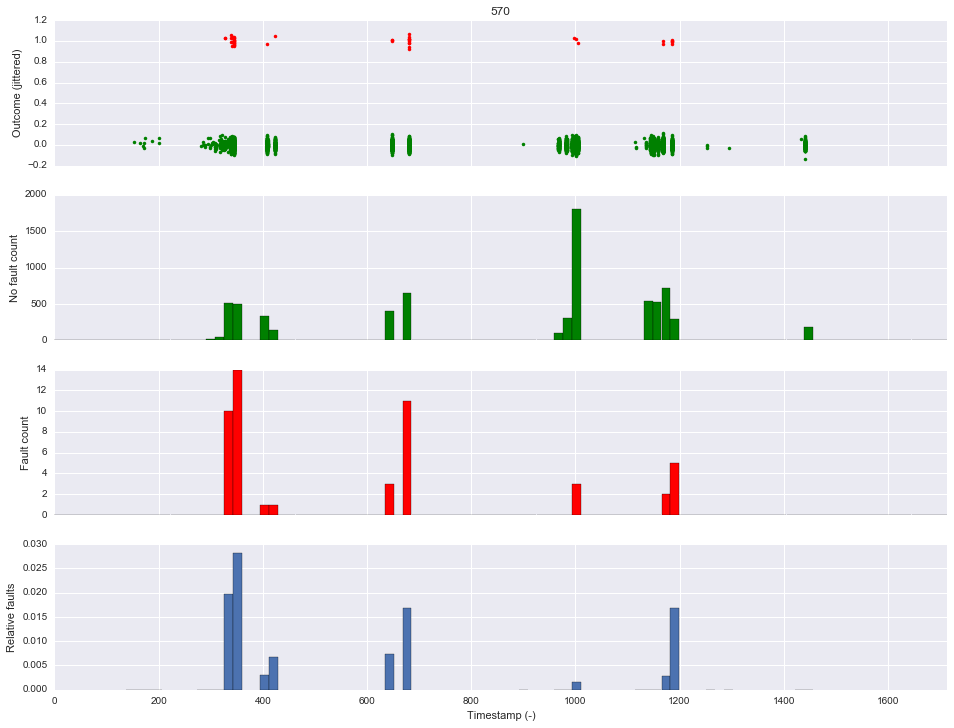

In [104]:
line_nr = 1
station_nr = 25
sample_feature = date_info[(date_info.line==line_nr) & (date_info.station==station_nr)].sample(1)

# Stations 29 - 37 experienced a stop with a high response when starting up again

print sample_feature

ncol = date_info[date_info.feature_nr==sample_feature.ref_feat_nr.iloc[0]+1].index[0]

plot_dates_outcome_feature(date_data, ncol, time_window=100)

In [86]:
# Do 2D visualization of relative amount of faults in time
def calculate_rel_fault_time(line=3):
    ''' returns the time windowed relative amount of faults for each feature in this line 
    as pandas dataframe'''
    features = date_info[(date_info.line==line)].ref_feat_nr.values + 1
    feat_cols = date_info[date_info.feature_nr.isin(features)].index.values

    for i, ncol in enumerate(feat_cols):
        if not i % 100:
            print('Calculating time windows {} of {}'.format(i, len(feat_cols)))
        bins, f_no_fault, f_fault = get_faults_time_windowed(date_data, ncol, 100)
        #print f_no_fault
        r_fault = np.divide(f_fault.astype(float), f_no_fault)

        if not i:
            df = pd.DataFrame(r_fault, index=bins, columns=[ncol])
        else:
            df[ncol] = r_fault

    df.fillna(0, inplace=True)
    
    return df

In [50]:
time_data_0 = calculate_rel_fault_time(0)
time_data_1 = calculate_rel_fault_time(1)
time_data_2 = calculate_rel_fault_time(2)
time_data_3 = calculate_rel_fault_time(3)

Calculating time windows 0 of 621
Calculating time windows 100 of 621
Calculating time windows 200 of 621
Calculating time windows 300 of 621
Calculating time windows 400 of 621
Calculating time windows 500 of 621
Calculating time windows 600 of 621


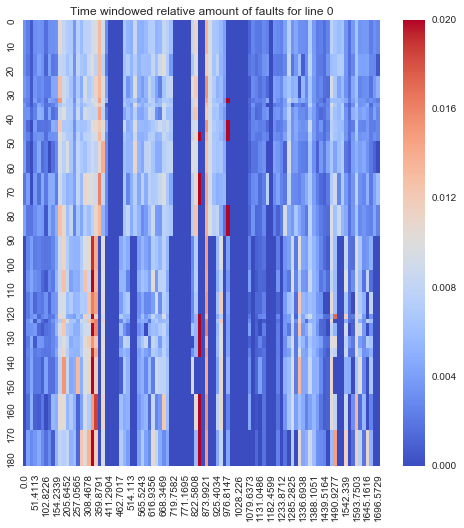

In [88]:
plt.figure(figsize=(8,8))
ax = sns.heatmap(time_data_0.T, vmin=0.0, vmax=0.02, yticklabels=10, xticklabels=3, cmap="coolwarm")
ax.set_title('Time windowed relative amount of faults for line 0')

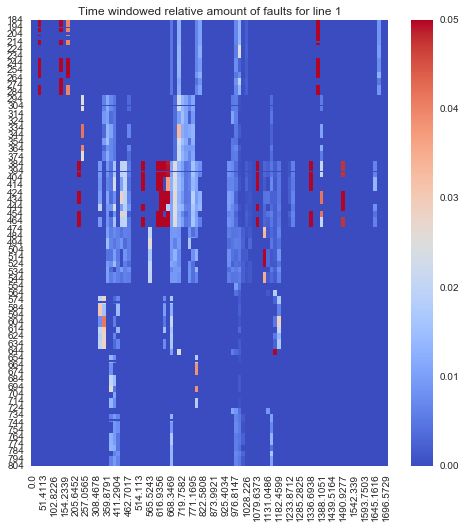

In [89]:
plt.figure(figsize=(8,8))
ax = sns.heatmap(time_data_1.T, vmin=0.0, vmax=0.05, yticklabels=10, xticklabels=3, cmap="coolwarm")
ax.set_title('Time windowed relative amount of faults for line 1')

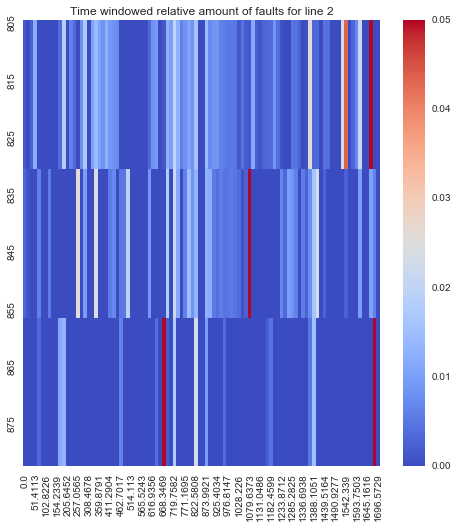

In [90]:
plt.figure(figsize=(8,8))
ax = sns.heatmap(time_data_2.T, vmin=0.0, vmax=0.05, yticklabels=10, xticklabels=3, cmap="coolwarm")
ax.set_title('Time windowed relative amount of faults for line 2')

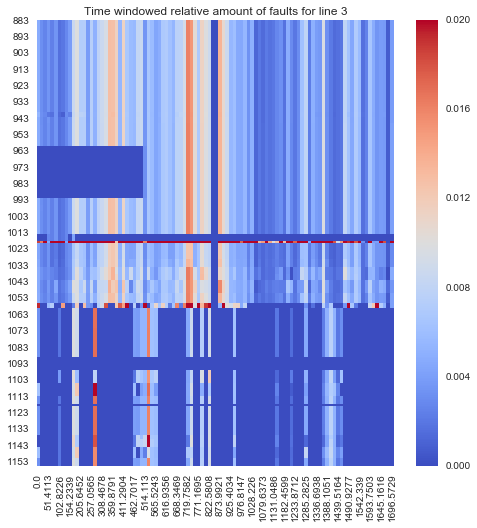

In [93]:
plt.figure(figsize=(8,8))
ax = sns.heatmap(time_data_3.T, vmin=0.0, vmax=0.02, yticklabels=10, xticklabels=3, cmap="coolwarm")
ax.set_title('Time windowed relative amount of faults for line 3')